## Team 2413:
- Maryam Gholami Shiri (2013071)
- Muhammad Usama Qasim (2040472)
- Laura Schulze (2122311)
- Savina Tsichli (10738280)

# Exercise 1

Analyze the data file provided at the lesson with CNNs. Each of the three classes contains a part of
a signal with N values, in which there could be the addition of a deterministic pattern of length
P<N. All patterns have the same length P (in the notebook), but their shape depends on the class,
and their position varies from sample to sample.

The following code is taken from the lecture notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

### Read Data

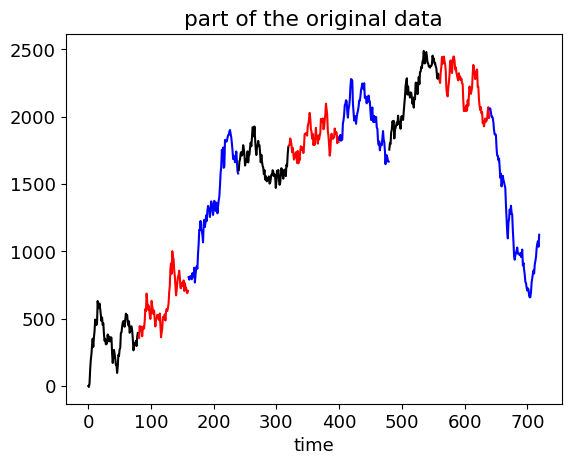

data:  4000


In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale Data, split train/val

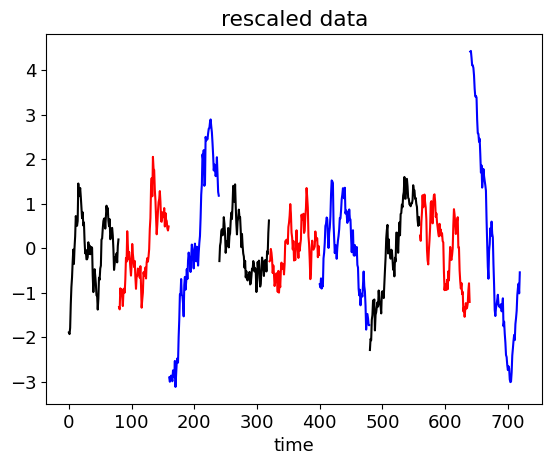

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## 1.1
The lesson discussed two CNN versions: one ending with a global max pooling layer (G), and one
ending with a dense layer (D).
Choose one of the two G and D versions for the remaining exercise, motivating your choice.

In [16]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0, optimizer=keras.optimizers.Adam()):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=5, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = optimizer
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

In [5]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

Trying **Version D** (dense layer last):

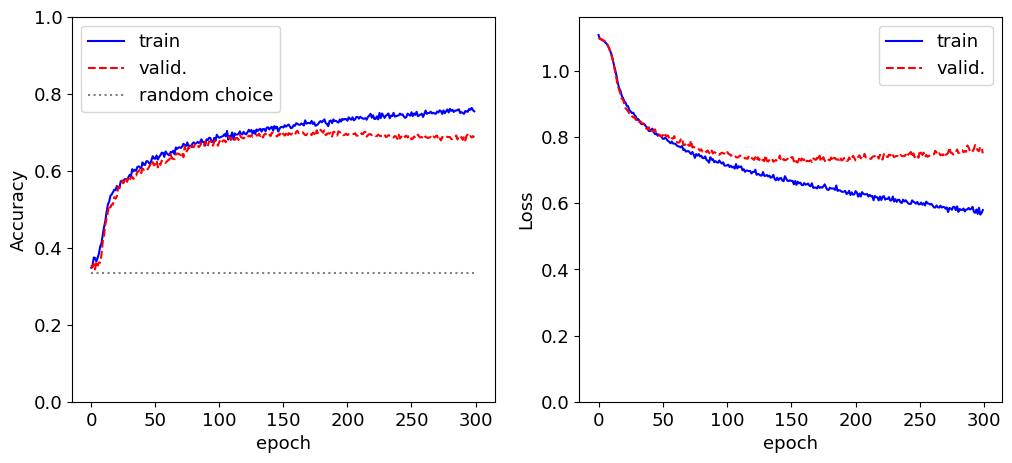

In [7]:
NCONV=1 # dense layer

modelD=build_model(NCONV=NCONV,KS=11)
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
modelD.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 300

fitD = modelD.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 

Show_history(fitD)

Trying **Version G** (global max pooling layer last):

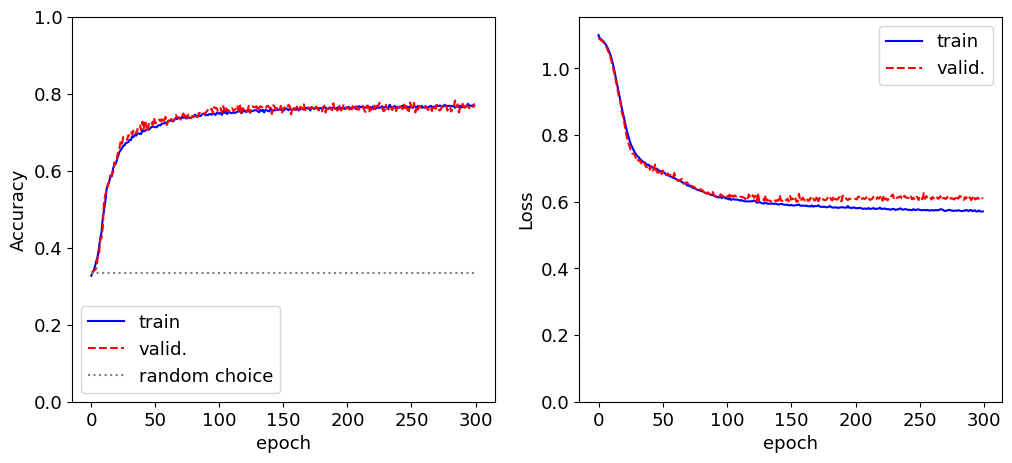

In [8]:
NCONV=2 # global max pooling layer last

modelG=build_model(NCONV=NCONV,KS=11)
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
modelG.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 300

fitG = modelG.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 

Show_history(fitG)

In [14]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


25/25 [==============================] - 0s 5ms/step


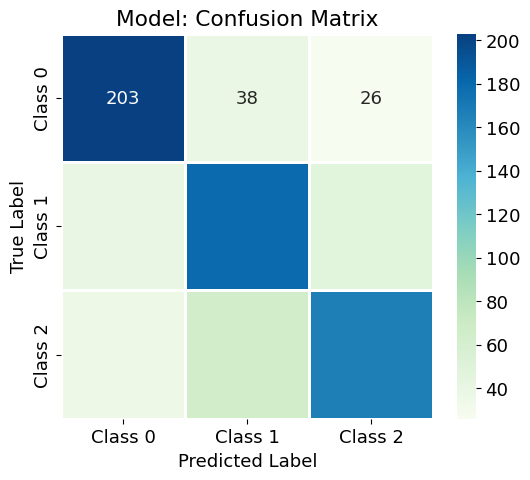

25/25 [==============================] - 0s 5ms/step


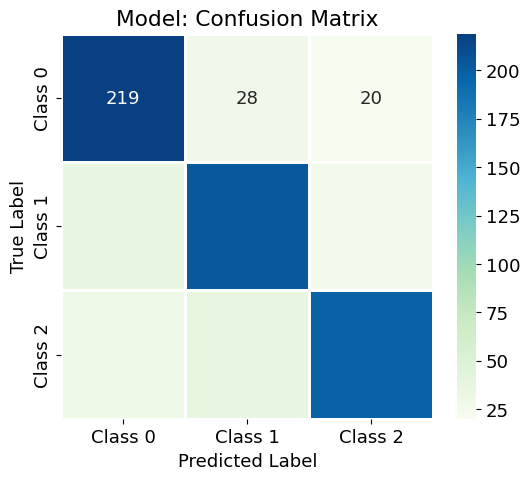

In [15]:
# version D
y_pred_val_D = np.array(modelD.predict(x_val))

# Take the class with the highest probability from the val predictions
max_y_pred_val_D = np.argmax(y_pred_val_D, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val_D)


# Version G
y_pred_val_G = np.array(modelG.predict(x_val))

# Take the class with the highest probability from the val predictions
max_y_pred_val_G = np.argmax(y_pred_val_G, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val_G)

We will proceed to use **Version G** (global max pooling as last layer). Version D appears to have a tendency to overfit, as the increasing difference between training accuracy and validation accuracy demonstrate. Version G achieves a better accuracy, as shown with the confusion matrices.

## 1.2
Try different optimizers, including at least Adam, RMSprop, and Nesterov. Each one should be
tested for at least five values of the learning rate η (for example, including 10-5, 10-4, 10-3). The
range could be different for different algorithms. Moreover, at least five fits per model should be
collected to obtain statistics with an average and standard deviation of the model’s validation
accuracy. Plot all results in a single panel of a figure as a function of η

In [17]:
# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
# opt = tf.keras.optimizers.Adam()

BATCH_SIZE = 200
EPOCHS = 300
NCONV=2 # version D

# TODO: iterate over optimizers & learning rates

lr = 10e-3
opt = tf.keras.optimizers.RMSprop(lr=lr)

model = build_model(NCONV=NCONV,KS=11, opt=opt)

# compile the model
# categorical_crossentropy, 3 output nodes
modelG.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])


fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 

# best way to get final accuracy?

TypeError: build_model() got an unexpected keyword argument 'opt'

## 1.3 
Choose one among the best CNNs in step 2 (there could be equivalent ones within error bars).
Using that CNN, try to understand the hidden patterns. Introduce regularization and study the
kernels of the first layer, also by varying their length and their number (respectively, KS and NF in the notebook). Report your findings, including eventually improved validation accuracy, thanks to
the regularization. However, note that this point’s scope differs from optimizing the validation
accuracy: it focuses on interpreting the kernel shapes.

The regularization is tuned by varying the parameter λ (in magnitude: 0, 10-5, 10-4, 10-3, etc.) of the
L2 (Ridge) regularization (see lambda in eqs.(43) and (52) in the review.) or the L1 (LASSO)
regularization. One can also try a mixed version (l1_l2, optional). Does the regularization provide
any significant improvement in understanding the weights in the filters?

## 1.4 (optional)
Try to improve the CNN’s performance by a random search in the hyperparameters’ space. The
performance is quantified again by the accuracy of the validation dataset.
To implement a “random search,” one can use the keras_tuner package:
https://keras.io/guides/keras_tuner/getting_started/
Hyperparameters that could be considered for tuning include:
- minibatch size
- activation units (sigmoid, ReLU, ELU, etc.)
- Minimizer (ADAM, RMSprop, Nesterov, etc.)
- dropout values
- number of layers
- rescaling of data

(above, we already varied the learning rate, KS, and NF; it is allowed to reconsider their variation).